# Entropy Analysis with PATRIC

### 1. First download the MLST of all genomes in PATRIC

`p3-all-genomes  --eq "genome_name, Staphylococcus_aureus" | p3-get-genome-data -a mlst > /data/patric_entropy/mlst.txt`

### 2. Get the features locus tags with mutations in ORF

Goal is to get the locus tags and download all sequences in the PATRIC local family of that ORF.
- mutations in ORF have '()' containing the aa changes
- PATRIC uses 'old_locus_tag' so we have to convert the current_locus_tag to old_tag


In [1]:
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.patches import Rectangle
from matplotlib.ticker import MultipleLocator

import seaborn as sns

import pandas as pd
import numpy as np
from Bio import SeqIO, Align
from scipy.stats import entropy


import os
import subprocess
import itertools
from collections import Counter
import tqdm
import tempfile
import glob
from shutil import copyfile


from scipy.signal import find_peaks

In [2]:
# load the kmer data and get orfs
kmer_md = pd.read_csv('data/dbgwas_postprocess/kmer_md.csv', index_col=0)
orf_md = kmer_md[(~kmer_md.TCH1516_mutation_map.isnull()) &
        (kmer_md.TCH1516_mutation_map.str.contains('\('))]
print(f'Number of ORFs: {orf_md.shape[0]}')
orf_md.head()

Number of ORFs: 86


,header,seq,nodes,networkFeature,mutations,TCH1516_kmer_pos,TCH1516_feats,TCH1516_mutation_pos,TCH1516_mutation_map,TCH1516_pUSA300HOUMR_kmer_pos,TCH1516_pUSA300HOUMR_feats,TCH1516_pUSA300HOUMR_mutation_pos,TCH1516_pUSA300HOUMR_mutation_map,TCH1516_pUSA01HOU_kmer_pos,TCH1516_pUSA01HOU_feats,TCH1516_pUSA01HOU_mutation_pos,TCH1516_pUSA01HOU_mutation_map
1,component11cycle0pheno1,CATAATTAAAGGAGTGATGATATTAATGAATAAACTTCAAGACACT...,n349758;n350864;n30123;n32034_rc,component11cycle0,38GA104,"(123778, 123636)",USA300HOU_RS00560,"[(123740, 123739)]",G13A(R4Q),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,component11cycle1pheno1,TAGAATTCCAGATATACCTGCACTAATCAAAGCTTCACCAAAATTT...,n156335;n151167;n367941;n228744,component11cycle1,32TC63,"(123454, 123549)",USA300HOU_RS00560,"[(123485, 123486)]",T267C(T89A),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
11,component126cycle0pheno1,AAAATATCCTAACGTAGCTGCAAGCGCGACTACACCATCATTTTTC...,n207282;n208653;n210916;n315359_rc;n318521;n32...,component126cycle0,31GA52,"(1839515, 1839598)",USA300HOU_RS09160,"[(1839545, 1839546)]",G223A(A74V),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
14,component61cycle0pheno1,TAATGCTTTGAAATCAGCCTGTAGAGTCAATAATATATCAATTATT...,n380911;n379974;n403167;n119614_rc,component61cycle0,37CT39,"(2128055, 2128131)",USA300HOU_RS10860,"[(2128091, 2128092)]",C843T(P281S),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
16,component101cycle0pheno1,AAAATAGTAATCATCATCCGAGGTAACCTGAAATCTAATAAGATTA...,n121642_rc;n117981;n30508_rc,component101cycle0,49CT166,"(724072, 723857)",USA300HOU_RS03510,"[(724023, 724022)]",C159T(E53K),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [3]:
# convert to old_locus_tag
otn = {}
# if no old locus tag, note the position of feature
new_lt_pos = {}
for refseq in SeqIO.parse('/home/saugat/Desktop/Reference/genome/TCH1516.gb', 'genbank'):
    for feats in refseq.features:
        try:
            locus_tag = feats.qualifiers['locus_tag'][0]
        except KeyError:
            continue
        else:
            try:
                old_locus_tag = feats.qualifiers['old_locus_tag'][0]
            except KeyError: # contains locus_tag but not old_locus_tag
                if locus_tag in orf_md.TCH1516_feats.values:
                    new_lt_pos.update({locus_tag: (int(feats.location.start),
                                                  int(feats.location.end))})
            else:
                if locus_tag in orf_md.TCH1516_feats.values:
                    otn.update({locus_tag: old_locus_tag})

In [4]:
# get the local pfam group
lt_to_pfam = {}
patric_tch = pd.read_csv('data/patric_entropy/PATRIC_TCH1516_feature.csv')
for lt in otn:
    match = patric_tch[patric_tch['RefSeq Locus Tag'] == otn[lt]]
    try:
        lt_to_pfam.update({lt: match['PATRIC genus-specific families (PLfams)'].values[0]})
    except IndexError:
        continue


# fmtB 'USA300HOU_2150/ USA300HOU_RS11650' is missing for some reason, add manually
lt_to_pfam.update({'USA300HOU_RS11650': 'PLF_1279_00001147'})
len(lt_to_pfam)

79

### 3. Download all the sequences from the pfam 

In [5]:
def get_feats_seq(feat_info, fout, dna=False):
    """"
    Downloads all the sequences for the specified local protein family in tsv format.
    Currently restricted to Staphylococcus aureus
    """
    print(f'\t-Getting feature seq for {feat_info} from PATRIC')
    cmd1 = ['p3-echo', feat_info]
    cmd2 = ['p3-get-family-features', '--ftype', 'local', '--attr', 'patric_id', '--eq', "genome_name, Staphylococcus aureus"]
    cmd3 = ['p3-get-feature-sequence']
    if dna:
        cmd3.append('--dna')
    
    p1 = subprocess.Popen(cmd1, stdout=subprocess.PIPE, stderr=subprocess.PIPE)
    p2 = subprocess.Popen(cmd2, stdin=p1.stdout, stdout=subprocess.PIPE)
    with open(fout, 'w') as pres:
        p3 = subprocess.Popen(cmd3, stdin=p2.stdout, stdout=pres)
    p1.wait()
    p2.wait()
    p3.wait()

In [ ]:
fadir = 'data/patric_entropy/PLF_fasta_files/'
for lt in lt_to_pfam:
    fout = os.path.join(fadir, lt + '_PLF.fa')
    get_feats_seq(lt_to_pfam[lt], fout, dna=True)

### 4. For each pfam, run multiple sequence alignment (MSA) with MAFFT to align the sequences and measure entropy at each position

In [11]:
alndir = 'data/patric_entropy/alignment_files/'
run_mafft = ['src/run_mafft.py', fadir, alndir, '--thread', 8]
# subprocess.call(run_mafft)

### 5.  Get the MLST distribution
The goal is to find clonal complex(CC) specific hotspots. But, we only want to utilize CCs that have >=450 sequences. So get the distribution of sequences for each clonal complex. 

In [3]:
mlst_df = pd.read_csv('data/patric_entropy/mlst.txt', sep='\t', dtype={'genome.genome_id': str})
mlst_df.head()

,genome.genome_id,genome.mlst
0,1280.15381,MLST.Staphylococcus_aureus.1245
1,703339.3,MLST.Staphylococcus_aureus.225
2,1280.15378,MLST.Staphylococcus_aureus.2574
3,1280.15371,MLST.Staphylococcus_aureus.97
4,1413559.3,MLST.Staphylococcus_aureus.398


In [4]:
# clean up some of the names
for idx, row in mlst_df[~mlst_df['genome.mlst'].str.contains('MLST')].iterrows():
    mlst = 'MLST.Staphylococcus_aureus.' + row['genome.mlst'].replace('ST', '')
    mlst_df.loc[idx, 'genome.mlst'] = mlst

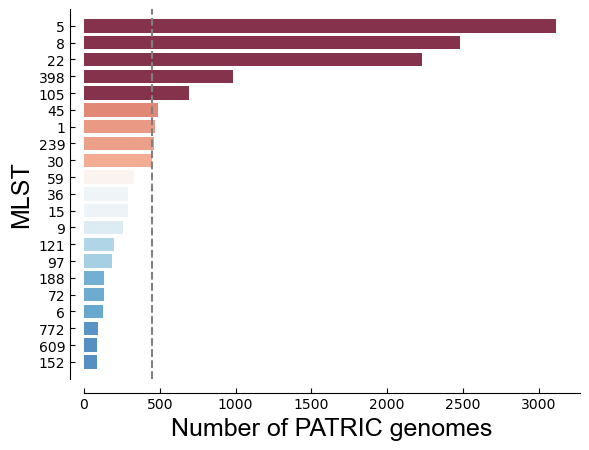

In [21]:
min_count = 450
value_counts = mlst_df['genome.mlst'].value_counts()[20::-1]
# colors = ['red' if ct >= 450 else 'blue' for ct in value_counts]
data_color_normalized = [(i * 5) / float(max(value_counts)) for i in value_counts.values]
my_cmap = plt.cm.get_cmap('RdBu_r')
colors = my_cmap(data_color_normalized)

ylabels = value_counts.index.str.replace('MLST.Staphylococcus_aureus.', '')
fig, ax = plt.subplots()
ax.tick_params(which='both', axis='both', direction='in', reset=True,
               top=False, right=False)

ax.barh(np.arange(len(value_counts)), value_counts, color=colors, alpha=0.8)
_ = ax.set_yticks(ticks=np.arange(len(value_counts)))
_ = ax.set_yticklabels(labels=ylabels)
ax.set_ylabel('MLST', fontname='Arial', fontsize=18)

ax.set_xlabel('Number of PATRIC genomes', fontname='Arial', fontsize=18)
ax.vlines(min_count, -1, len(value_counts), linestyles='--', color='gray')
sns.despine(offset=10)
ax.set_ylim(-1, len(value_counts))
plt.savefig('figures/PATRIC_mlst_genome_dist.svg')

In [9]:
selected_mlst = mlst_df.groupby('genome.mlst').filter(lambda x: len(x) >= 0)['genome.mlst'].unique()

### 6. Calculate entropy per clonal complex

In [10]:
genome_to_mlst = dict(mlst_df.set_index('genome.genome_id')['genome.mlst'])

In [11]:
def read_aln(aln_file, genome_to_mlst, selected_mlst):
    """
    Concats aligned sequences if they are from the selected_mlst
    
    Parameters
    ----------
    aln_file: str
        path to alignment file
    genome_to_mlst: dict
        dictionary mapping the genome PATRIC id to mlst
    selected_mlst: list, set
        list of MLST to be included
        
    returns
    -------
    concat_seq: str
        sequnence of concatnated alignment sequences; only sequences from the genomes belonging
        to selected_mlst will be concatenated
    count: int
        number of sequences that were concatenated
    """
    ctseq = ''
    count = 0
    for seq in SeqIO.parse(aln_file, 'fasta'):
        gen = seq.id.split('.peg')[0].split('fig|')[-1]
        try:
            mlst = genome_to_mlst[gen]
        except KeyError:
            continue
        else:
            if mlst in selected_mlst:
                ctseq += str(seq.seq)
                count += 1
    return ctseq, count

In [12]:
def getpos_seq(ctseq, count, start, total_len, indiv_len):
    """
    Yields the sequences at the next position of the ctseq i.e. sequence at the 0th
    position of all the aligned sequences. The length of the returned sequence is 
    equal to count; one per aligned sequence. 
    
    Parameters
    ----------
    ctseq: str
        concatenated alignment sequences
    count: int
        number of concatenated sequences
    
    yields
    -------
    pos_seq: str
        sequence at the next position of each of the aligned sequences
    """
    
    return [ctseq[j] for j in np.arange(start, total_len, indiv_len).astype(int)]


def calc_entropy(sequences):
    """
    Calculates the entropy of the input string
    
    Parameters
    ----------
    sequences: str
        sequence to calculate entropy for
    
    returns
    -------
    entropy: float
        the entropy value of the input string
    """
    
    freqs = [i/len(sequences) for i in Counter(sequences).values()]
    return entropy(freqs)

In [20]:
# non_cc8 = ['MLST.Staphylococcus_aureus.398',
#        'MLST.Staphylococcus_aureus.5', 'MLST.Staphylococcus_aureus.105',
#        'MLST.Staphylococcus_aureus.45', 'MLST.Staphylococcus_aureus.22',
#        'MLST.Staphylococcus_aureus.1']
# cc8 = [ 'MLST.Staphylococcus_aureus.8']
# cc5 = ['MLST.Staphylococcus_aureus.5']

# all_class = ['MLST.Staphylococcus_aureus.398',
#        'MLST.Staphylococcus_aureus.5', 'MLST.Staphylococcus_aureus.105',
#        'MLST.Staphylococcus_aureus.45', 'MLST.Staphylococcus_aureus.22',
#        'MLST.Staphylococcus_aureus.1', 'MLST.Staphylococcus_aureus.8']

In [13]:
cc8 = [ 'MLST.Staphylococcus_aureus.8']
non_cc8 = [i for i in mlst_df['genome.mlst'].unique() if i not in cc8 and '239' not in i]

In [14]:
def get_plot(fname, plot=True):
#     fname = 'USA300HOU_RS13015_PLF'
    ctseq, count = read_aln('data/patric_entropy/alignment_files_aa/' + fname,
                           genome_to_mlst, non_cc8)
    # ctseq, count = read_aln('data/patric_entropy/alignment_files/USA300HOU_RS01995_PLF',
    #                        genome_to_mlst, selected_mlst)
    total_len = len(ctseq)
    indiv_len = total_len / count
    ent = []
    sq_dict = {}
    for start in np.arange(indiv_len):
        sq = getpos_seq(ctseq, count, start, total_len, indiv_len)
        entropy = calc_entropy(sq)
        if entropy >= 0.2:
            sq_dict.update({start: sq})
        ent.append(calc_entropy(sq))

    ctseq, count = read_aln('data/patric_entropy/alignment_files_aa/' + fname,
                           genome_to_mlst, cc8)
    # ctseq, count = read_aln('data/patric_entropy/alignment_files/USA300HOU_RS01995_PLF',
    #                        genome_to_mlst, selected_mlst)
    total_len = len(ctseq)
    indiv_len = total_len / count
    cc8_ent = []
    sq_dict_cc8 = {}
    for start in np.arange(indiv_len):
        sq = getpos_seq(ctseq, count, start, total_len, indiv_len)
        entropy = calc_entropy(sq)
        if entropy >= 0.2:
            sq_dict_cc8.update({start: sq})
        cc8_ent.append(entropy)
    if plot:
        fig, ax = plt.subplots(2)
        ax[0].set_title(lt_to_prod[fname.replace('_PLF', '')] + fname)
        ax[0].plot(ent)
        ax[0].set_ylim(0, 0.8)
        ax[1].plot(cc8_ent)
        ax[1].set_ylim(0, 0.8)
    return ent, cc8_ent, sq_dict, sq_dict_cc8

In [15]:
lt_to_prod = {}
for refseq in SeqIO.parse('/home/saugat/Desktop/Reference/genome/TCH1516.gb', 'genbank'):
    for feat in refseq.features:
        if feat.type != 'CDS':
            continue
        lt_to_prod.update({feat.qualifiers['locus_tag'][0]: feat.qualifiers['product'][0]})

In [16]:
fnames = [i for i in os.listdir('data/patric_entropy/alignment_files_aa/')]
len(fnames)

61

In [337]:
aln_counts.values()

dict_values([289, 16863, 16169, 192, 10203, 2214, 16363, 16556, 16269, 14588, 16230, 10377, 16144, 17369, 16246, 16217, 15006, 16226, 16434, 16416, 16311, 16743, 4846, 16259, 14517, 16270, 16235, 17686, 14402, 0, 11724, 16227, 16502, 16358, 16200, 16377, 16217, 9435, 16329, 16281, 16194, 16280, 1510, 16259, 16222, 16230, 16313, 16223, 16218, 9261, 12885, 16202, 12352, 16985, 18155, 16213, 16222, 16215, 16418, 12737, 16273])

In [331]:
aln_counts = {}
for fname in tqdm.tqdm(fnames):
    _, count = ctseq, count = read_aln('data/patric_entropy/alignment_files_aa/' + fname,
                           genome_to_mlst, mlst_df['genome.mlst'].values)
    aln_counts.update({fname:count})

100%|██████████| 61/61 [02:55<00:00,  2.87s/it]


In [ ]:
problems = [3, # no peaks
           29, #divison by zero
           36, #no peak in other
           42, #no cc8 peaks
           44]

In [106]:
# individually double check each of the ones and choose to include
included = [0, 2, 4, 5, 8, 10, 11 , 12, 14, 15, 16, 17, 19, 20, 21, 23, 24,
           25, 26, 28, 32, 34, 35, 37, 39, 41, 47, 48, 51, 52, 57, 58, 59, 60]
#maybe 33

In [254]:
n = 0

USA300HOU_RS00820 NAD-dependent epimerase/dehydratase family protein
Length: 342
['C222A(D74Y)']
CC8 peaks:  [74]
nonCC8 peaks:  [74]


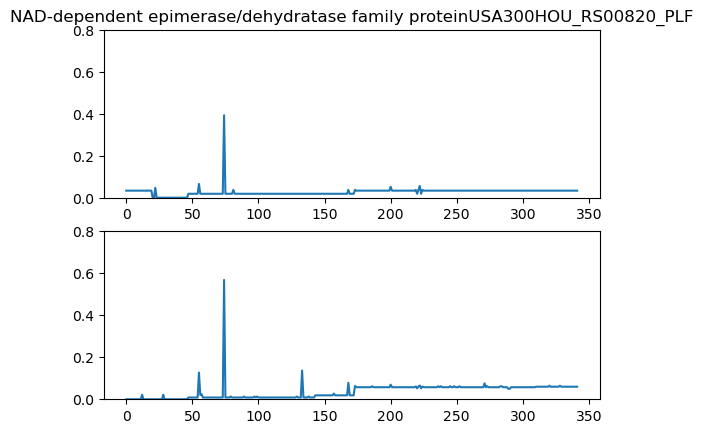

In [17]:
name = 'USA300HOU_RS00820_PLF'

lt = name.replace('_PLF', '')
print(lt, lt_to_prod[lt])
ent, cc8_ent, sq_dict, sq_dict_usa300 = get_plot(name)
print('Length:', len(ent))
print(kmer_md[kmer_md.TCH1516_feats == lt]['TCH1516_mutation_map'].values)
print('CC8 peaks: ', find_peaks(cc8_ent, prominence=(0.2))[0])
print('nonCC8 peaks: ', find_peaks(ent, prominence=(0.2))[0])

0
USA300HOU_RS03100 DUF1450 domain-containing protein
Length: 113
['A286T(E95V)']
CC8 peaks:  [95]
nonCC8 peaks:  [77]


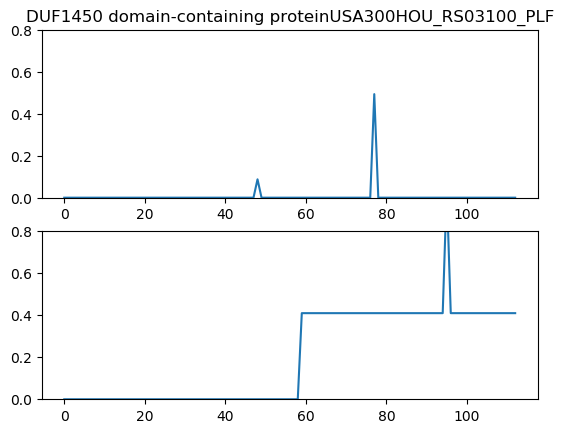

In [255]:
name = fnames[included[n]]

lt = name.replace('_PLF', '')
print(n)
print(lt, lt_to_prod[lt])
ent, cc8_ent, sq_dict, sq_dict_usa300 = get_plot(name)
print('Length:', len(ent))
print(kmer_md[kmer_md.TCH1516_feats == lt]['TCH1516_mutation_map'].values)
print('CC8 peaks: ', find_peaks(cc8_ent, prominence=(0.2))[0])
print('nonCC8 peaks: ', find_peaks(ent, prominence=(0.2))[0])
n += 1

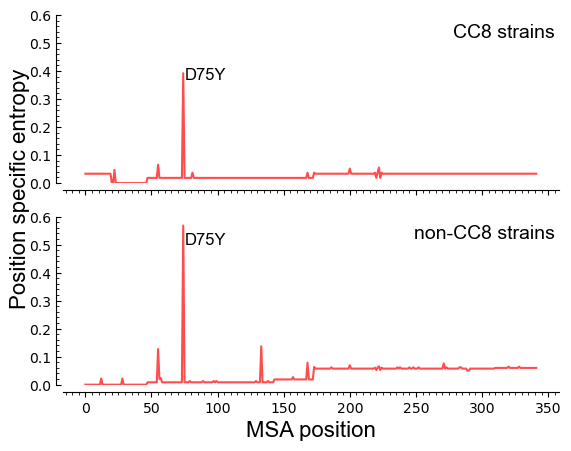

In [329]:
sns.reset_orig()
fig, ax = plt.subplots(2, sharex=True, sharey=True)
ax[0].plot(ent, color='red', alpha=0.7)
ax[0].set_ylim(0, 0.6)
ax[1].plot(cc8_ent, color='red', alpha=0.7)
ax[1].set_ylim(0, 0.6)
ax[1].set_xlabel('MSA position', fontname='Arial', fontsize=16)
ax[1].text(-57, 0.7, 'Position specific entropy', va='center', rotation='vertical',
          fontname='Arial', fontsize=16)

ax[0].text(355, 0.52, 'CC8 strains', ha='right', fontname='Arial', fontsize=14)
ax[1].text(355, 0.52, 'non-CC8 strains', ha='right', fontname='Arial', fontsize=14)

ax[0].text(75, 0.37, 'D75Y', fontname='Arial', fontsize=12)
ax[1].text(75, 0.5, 'D75Y', fontname='Arial', fontsize=12)

ax[1].tick_params(which='both', axis='y', direction='in')
ax[0].tick_params(which='both', axis='y', direction='in')

ax[1].xaxis.set_minor_locator(MultipleLocator(5))
ax[1].yaxis.set_minor_locator(MultipleLocator(0.02))
ax[0].xaxis.set_minor_locator(MultipleLocator(5))
ax[0].yaxis.set_minor_locator(MultipleLocator(0.02))

sns.despine(offset=5)
plt.savefig('figures/Cap5e_entropy.svg')

# PATRIC entropy example

In [121]:
calc_entropy('TYARD')

calc_entropy('AAAKK')

calc_entropy('AAAKA')

0.5004024235381879

Text(0.5, 0, 'MSA Position')

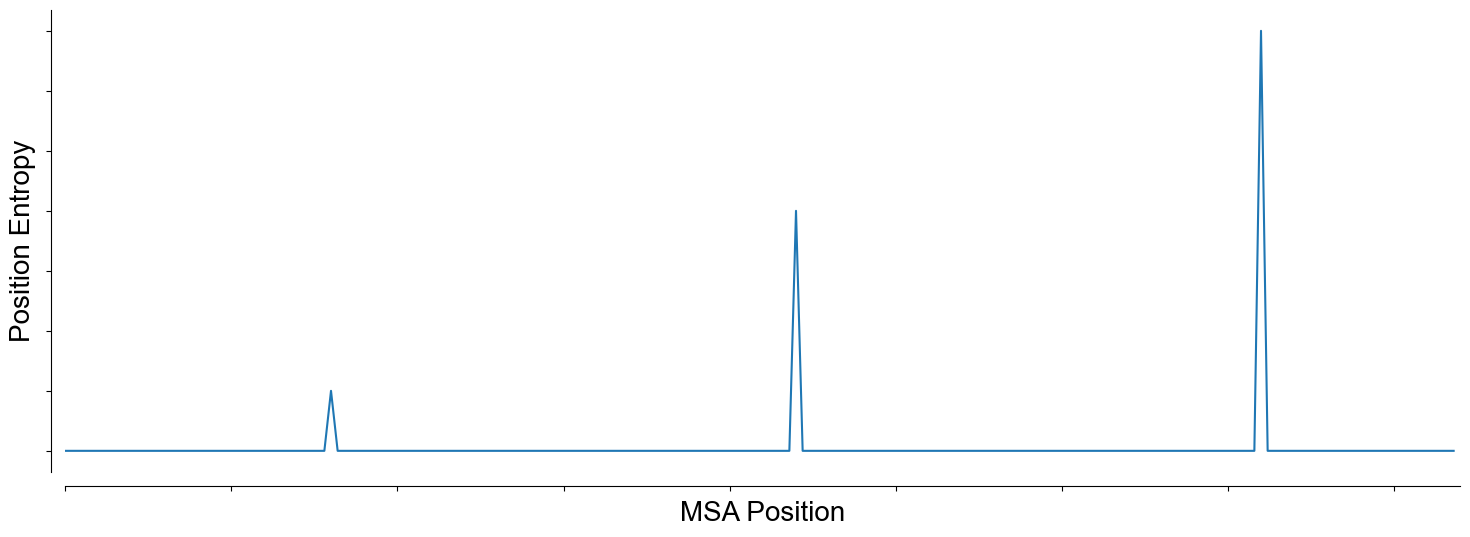

In [135]:
# ys = np.zeros(210)
# ys = ys + 0.1
fig, ax = plt.subplots(figsize=(18, 6))
ys[40] = 0.1
ys[110] = 0.4
ys[180] = 0.7
# ax.bar([40], [0.1], color='yellow')
# ax.bar([110], [0.4], color='orange')
# ax.bar([180], [0.7], color='red')
ax.plot(np.arange(210), ys)
ax.set_xlim(0, 210)

ax.set_xticklabels([])
ax.set_yticklabels([])

sns.despine(offset=10)

ax.set_ylabel('Position Entropy', fontname='Arial', fontsize=20)
ax.set_xlabel('MSA Position', fontname='Arial', fontsize=20)



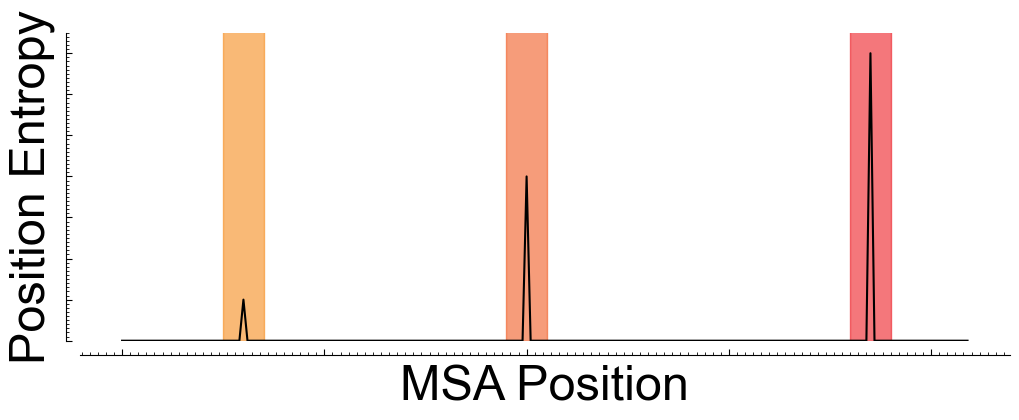

In [179]:
ys = np.zeros(210)
ys[30] = 0.1
ys[100] = 0.4
ys[185] = 0.7
fig, ax = plt.subplots(figsize=(12, 4))
ax.plot(np.arange(210), ys, color='black')
ax.set_ylim(0, 0.75)

rect = Rectangle((25, 0), 10, 0.8, alpha=0.6, color='#f68b1b')
ax.add_artist(rect)
rect = Rectangle((95, 0), 10, 0.8, alpha=0.6, color='#f15a22')
ax.add_artist(rect)
rect = Rectangle((180, 0), 10, 0.8, alpha=0.6, color='#ed1c24')
ax.add_artist(rect)

ax.set_xticklabels([])
ax.set_yticklabels([])

sns.despine(offset=10)

ax.set_ylabel('Position Entropy', fontname='Arial', fontsize=35)
ax.set_xlabel('MSA Position', fontname='Arial', fontsize=35)

ax.tick_params(which='both', axis='both', direction='in')
ax.tick_params(which='major', axis='both', length=8)
ax.tick_params(which='major', axis='both', length=4)


ax.xaxis.set_minor_locator(MultipleLocator(2))
ax.yaxis.set_minor_locator(MultipleLocator(0.01))

plt.savefig('figures/entropy_example.svg')

In [ ]:
plt.scatter(np.arange(0))

In [213]:
Counter(sq_dict_usa300[103])

Counter({'M': 620, '-': 1870})

# Look at the distance

In [181]:
endata = pd.read_csv('data/patric_entropy/Entropy_data', index_col=0)

# reasons for drop-(1) silent mutation, (2) no peaks on nonCc8 i.e. unique cc8 mutation
drop = ['USA300HOU_RS02380', 'USA300HOU_RS06720', 'USA300HOU_RS12805',
        'USA300HOU_RS04385', 'USA300HOU_RS11870', 'USA300HOU_RS07190',
       'USA300HOU_RS10800']
endata.drop(drop, inplace=True)
endata = endata.sort_values('Distance')

endata.head()


,Protein,Length,Mutation,CC8 Peak,Non-CC8 Peak,Distance
Locus Tag,,,,,,
USA300HOU_RS00820,NAD-dependent epimerase/dehydratase family pro...,342,C222A(D74Y),74,74.0,0
USA300HOU_RS08285,penicillin-binding protein 2,774,C2046T(D682N),706,707.0,1
USA300HOU_RS13015,type II toxin-antitoxin system Phd/YefM family...,116,[T73A(D24V)],27,28.0,1
USA300HOU_RS14000,alpha/beta hydrolase,336,G592A(S197L),208,209.0,1
USA300HOU_RS14425,flavin reductase family protein,445,C346T(G115D),321,319.0,2


In [202]:
endata

,Protein,Length,Mutation,CC8 Peak,Non-CC8 Peak,Distance
Locus Tag,,,,,,
USA300HOU_RS00820,NAD-dependent epimerase/dehydratase family pro...,342,C222A(D74Y),74,74.0,0
USA300HOU_RS08285,penicillin-binding protein 2,774,C2046T(D682N),706,707.0,1
USA300HOU_RS13015,type II toxin-antitoxin system Phd/YefM family...,116,[T73A(D24V)],27,28.0,1
USA300HOU_RS14000,alpha/beta hydrolase,336,G592A(S197L),208,209.0,1
USA300HOU_RS14425,flavin reductase family protein,445,C346T(G115D),321,319.0,2
USA300HOU_RS12255,MarR family transcriptional regulator,179,T421C(K140R),168,170.0,2
USA300HOU_RS04015,glycerate kinase,444,C618T(H206Y),212,215.0,3
USA300HOU_RS09160,PTS glucose transporter subunit IIBC,564,G223A(A74V),75,81.0,6
USA300HOU_RS00465,TfoX family protein,1235,C64G(T21R),37,46.0,9


In [297]:
for refseq in SeqIO.parse('/home/saugat/Desktop/Reference/genome/TCH1516.gb', 'genbank'):
    for feat in refseq.features:
        try:
            if feat.qualifiers['locus_tag'][0] == 'USA300HOU_RS03915':
                print(feat.qualifiers['translation'][0])
                seq = feat.qualifiers['translation'][0]
        except KeyError:
            continue

MTRKSIAIDMDEVLADTLGEIIDAVNFRADLGIKMEALNGQKLKHVIPEHDGLITEVLRESGFFRHLKVMPYAQEVVKKLTEHYDVYIATAAMDVPTSFSDKYEWLLEFFPFLDPQHFVFCGRKNIVKADYLIDDNPRQLEIFTGTPIMFTAVHNINDDRFERVNSWKDVEQYFLDNIEK


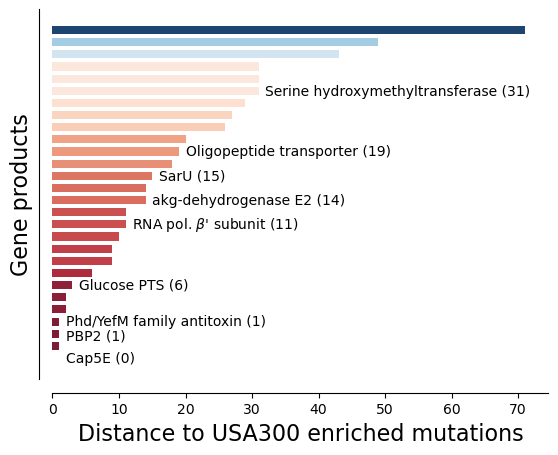

In [283]:
y = endata.Distance.values
my_cmap = plt.get_cmap("RdBu")
rescale = lambda y: (y - np.min(y)) / (np.max(y) - np.min(y))

plt.barh(np.arange(len(endata)) * 1.2, y, color=my_cmap(rescale(y)), alpha=0.9)
plt.xlabel('Distance to USA300 enriched mutations', fontsize=16)
plt.ylabel('Gene products', fontsize=16)
_ = plt.yticks([], [])

_ = plt.text(2, 0, 'Cap5E (0)', va='center')
_ = plt.text(2, 1.8 * 1.2, 'PBP2 (1)', va='center')
_ = plt.text(2, 3 * 1.2, 'Phd/YefM family antitoxin (1)', va='center')
_ = plt.text(4, 6 * 1.2, 'Glucose PTS (6)', va='center')
_ = plt.text(12, 11 * 1.2, r"RNA pol. $\beta$' subunit (11)", va='center')
_ = plt.text(15, 13 * 1.2, 'akg-dehydrogenase E2 (14)', va='center')
_ = plt.text(16, 15 * 1.2, 'SarU (15)', va='center')
_ = plt.text(20, 17 * 1.2, 'Oligopeptide transporter (19)', va='center')
_ = plt.text(32, 22 * 1.2, 'Serine hydroxymethyltransferase (31)', va='center')

sns.despine(offset=10)
plt.savefig('figures/ORF_peak_distance.svg')

In [ ]:
blastout = glob.glob(blast_output + '*')[0]
lt = os.path.basename(blastout).replace('.tsv', '')
refseq = next(SeqIO.parse(os.path.join(fa_dir, lt + '.faa'), 'fasta')).seq
blastdf = pd.read_csv(blastout, index_col=0, sep='\t', header=None)
blastdf = blastdf[(blastdf[2] >= 80) & (blastdf[3] >= len(refseq))]682

In [1063]:
ctseq, count = read_aln('data/patric_entropy/alignment_files_aa/' + name,
                           genome_to_mlst, cc8)

In [ ]:
df = pd.read_csv('blastout.txt', index_col=0, sep='\t', header=None)

In [1110]:
for refseq in SeqIO.parse('/home/saugat/Desktop/Reference/genome/TCH1516.gb', 'genbank'):
    for feat in refseq.features:
        try:
            lt_name = feat.qualifiers['locus_tag'][0]
        except KeyError:
            continue
        else:
            if feat.type == 'CDS' and lt_name in lt:
                seq = feat.qualifiers['translation'][0]
                print(f'>{lt_name}\n{seq}\n')

>USA300HOU_RS09160
MYKFFQNLGRSLMLPVAILPAAAIIAGIGNTLNALHATPKIAMFFTTVGTTILEQLGILFAIGVAIGMAKKNDGVVALAATLGYFLVTVVLSPMKLAPLLGMKASEINSAFEKMNNGNVFVGIVIGLIAAYAYNKFSETELPLALSFFSGKRLVPIMTAFYCTFLVVILLFLWPLLYSWIVKFGESIVGLGSFGAFIYGVANRLLIPTGLHHALNSVFWFDTIGINDIGKFQSGKDAIKGITGRYQAGFFPIMMFGIPAAALAMYHTAKTTQKKQVYGWFLASSVAAFFVGVTEPIEFAFMFVAPILYVVHALLTGLSLFIAATFHWTAGFSFSAGLIDYVLSLINPVSNHPLMLLVQGVVFFILYYVIFRVVIQVFNLNTIGRGENELVDPTVVKDNIAPGENDIKQSKYHQHAIQILEGLGGQENIVNLTNCATRLRLELKDTSIIDKQKIKNAGAVGVTVNGKHSTQVIVGTHVQQVADEIEKHL



In [389]:
ctseq, count = read_aln('data/patric_entropy/alignment_files/' + fnames[46],
                           genome_to_mlst, cc8)

### Amino acid analysis

In [1175]:
# Get all the locus tags with non-synonymous SNPs
aa_mut = []
for idx, row in kmer_md.dropna(subset=['TCH1516_mutation_map']).iterrows():
    if '(' in row.TCH1516_mutation_map and ';' not in row.TCH1516_mutation_map:
        mt = row.TCH1516_mutation_map.split('(')[-1].split(')')[0]
        if mt[0] == mt[-1]:
            continue
        aa_mut.append(row.TCH1516_feats)
len(aa_mut)

61

In [1176]:
def translate_file(infile, outdir):
    outfile = os.path.join(outdir, os.path.basename(infile))
    if os.path.isfile(outfile):
        print(f'Skipping {outfile}; already exists')
        return
    with open(outfile, 'w') as fout:
        for refseq in SeqIO.parse(infile, 'fasta'):
            fout.write(f'>{refseq.id}\n{refseq.seq.translate()}\n')

In [1177]:
# translate the PLF fasta files from nucl to prot sequence
fadir = 'data/patric_entropy/PLF_fasta_files/'
for files in os.listdir(fadir):
    if files.split('_PLF')[0] in aa_mut:
        print(count, files)
        translate_file(os.path.join(fadir, files), 'data/patric_entropy/PLF_fasta_files_aa/')
        count += 1

1 USA300HOU_RS14295_PLF.fa


/home/saugat/anaconda3/envs/ete3/lib/python3.6/site-packages/Bio/Seq.py:2983: BiopythonWarning: Partial codon, len(sequence) not a multiple of three. Explicitly trim the sequence or add trailing N before translation. This may become an error in future.
  BiopythonWarning,


2 USA300HOU_RS04385_PLF.fa
3 USA300HOU_RS02380_PLF.fa
4 USA300HOU_RS02990_PLF.fa
5 USA300HOU_RS08100_PLF.fa
6 USA300HOU_RS10860_PLF.fa
7 USA300HOU_RS07190_PLF.fa
8 USA300HOU_RS13880_PLF.fa
9 USA300HOU_RS09725_PLF.fa
10 USA300HOU_RS11410_PLF.fa
11 USA300HOU_RS08465_PLF.fa
Skipping data/patric_entropy/PLF_fasta_files_aa/USA300HOU_RS08465_PLF.fa; already exists
12 USA300HOU_RS07340_PLF.fa
Skipping data/patric_entropy/PLF_fasta_files_aa/USA300HOU_RS07340_PLF.fa; already exists
13 USA300HOU_RS13270_PLF.fa
14 USA300HOU_RS04765_PLF.fa
15 USA300HOU_RS00465_PLF.fa
16 USA300HOU_RS04920_PLF.fa
17 USA300HOU_RS09160_PLF.fa
Skipping data/patric_entropy/PLF_fasta_files_aa/USA300HOU_RS09160_PLF.fa; already exists
18 USA300HOU_RS02280_PLF.fa
19 USA300HOU_RS03720_PLF.fa
Skipping data/patric_entropy/PLF_fasta_files_aa/USA300HOU_RS03720_PLF.fa; already exists
20 USA300HOU_RS05470_PLF.fa
Skipping data/patric_entropy/PLF_fasta_files_aa/USA300HOU_RS05470_PLF.fa; already exists
21 USA300HOU_RS00910_PLF.fa
22 

In [ ]:
# align to the PLF files
fadir = 'data/patric_entropy/PLF_fasta_files_aa/'
alndir = 'data/patric_entropy/alignment_files_aa/'
run_mafft = ['src/run_mafft.py', fadir, alndir, '--thread', '7']
subprocess.call(run_mafft)

In [1178]:
# get the reference sequence of the genes with non-synonymous SNPs
with open('aa_mut.faa', 'w') as fout:
    for refseq in SeqIO.parse('/home/saugat/Desktop/Reference/genome/TCH1516.gb', 'genbank'):
        for feats in refseq.features:
            if feats.type != 'CDS':
                continue
            try:
                lt = feats.qualifiers['locus_tag'][0]
                product = feats.qualifiers['product'][0]
                seq = feats.qualifiers['translation'][0]
            except KeyError:
                continue
            else:
                if lt in aa_mut:
                    fout.write(f'>{lt}|{product}\n{seq}\n')

In [564]:
# create individual reference files for each of the reference features
path = 'data/patric_entropy/reference_files_aa/'
for refseq in SeqIO.parse('aa_mut.faa', 'fasta'):
    name = refseq.id.split('|')[0]
    fout = os.path.join(path, name + '.faa')
    with open(fout, 'w') as f:
        f.write(f'>{refseq.id}\n{refseq.seq}\n')

In [919]:
def read_fasta(aln_file, genome_to_mlst, selected_mlst, selected_seq):
    """
    Concats aligned sequences if they are from the selected_mlst
    
    Parameters
    ----------
    aln_file: str
        path to alignment file
    genome_to_mlst: dict
        dictionary mapping the genome PATRIC id to mlst
    selected_mlst: list, set
        list of MLST to be included
        
    returns
    -------
    concat_seq: str
        sequnence of concatnated alignment sequences; only sequences from the genomes belonging
        to selected_mlst will be concatenated
    count: int
        number of sequences that were concatenated
    """
    ctseq = ''
    count = 0
    for seq in SeqIO.parse(aln_file, 'fasta'):
        if seq.id not in selected_seq:
            continue
        gen = seq.id.split('.peg')[0].split('fig|')[-1]
        try:
            mlst = genome_to_mlst[gen]
        except KeyError:
            continue
        else:
            if mlst in selected_mlst:
                ctseq += str(seq.seq)
                count += 1
    return ctseq, count

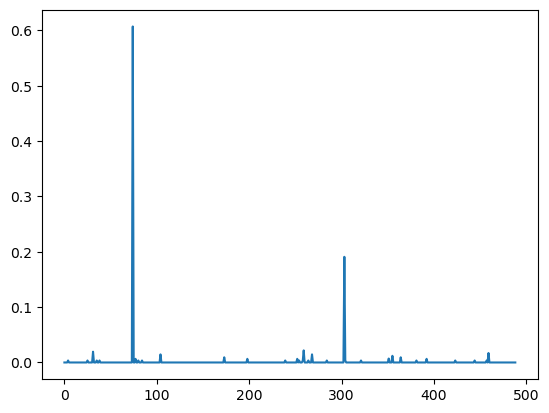

In [735]:
ctseq, count = read_aln('data/patric_entropy/PLF_fasta_files_aa/USA300HOU_RS09160_PLF.fa',
                       genome_to_mlst, cc8, selected[1].values)

total_len = len(ctseq)
indiv_len = total_len / count
ent = []
for start in np.arange(indiv_len):
    sq = getpos_seq(ctseq, count, start, total_len, indiv_len)
    ent.append(calc_entropy(sq))
plt.plot(ent)

In [915]:
ctseq, count = read_aln('data/patric_entropy/alignment_files_aa/USA300HOU_RS00560_PLF',
                       genome_to_mlst, non_cc8, selected[1].values)

total_len = len(ctseq)
indiv_len = total_len / count
ent = []
for start in np.arange(indiv_len):
    sq = getpos_seq(ctseq, count, start, total_len, indiv_len)
    ent.append(calc_entropy(sq))
plt.plot(ent)

ZeroDivisionError: division by zero

#### BLAST the nucl sequences
Sequences with mutations, synonymous and non-synonymous, within features

In [844]:
db_dir = 'data/patric_entropy/PLF_fasta_files/'
fa_dir = 'data/patric_entropy/reference_files/'
blast_output = 'data/patric_entropy/blast_out/nucl/'
fa_lt = [i.split('_PLF')[0] for i in os.listdir(db_dir)]

for refseq in SeqIO.parse('/home/saugat/Desktop/Reference/genome/TCH1516.gb', 'genbank'):
    for feat in refseq.features:
        try:
            lt = feat.qualifiers['locus_tag'][0]
        except KeyError:
            continue
        else:
            if lt in fa_lt:
                seq = str(feat.extract(refseq).seq)
                with open(os.path.join(fa_dir, lt + '.fna'), 'w') as fout:
                    fout.write(f'>{lt}\n{seq}\n')

with tempfile.TemporaryDirectory() as temp:
    #make blastdb
    for src in tqdm.tqdm(glob.glob(db_dir + '*')):
        fname = os.path.basename(src)
        dbfile = os.path.join(temp, fname)
        copyfile(src, dbfile)
        queryfile = os.path.join(fa_dir, fname.replace('_PLF.fa', '.fna'))
        outfile = os.path.join(blast_output, fname.replace('_PLF.fa', '.tsv'))
        
        subprocess.call(['makeblastdb', '-in', dbfile, '-dbtype', 'nucl'])
        subprocess.call(['blastn', '-db', dbfile, '-query', queryfile,
                         '-max_target_seqs', '50000', '-num_threads', '6',
                         '-outfmt','6','-out', outfile])

100%|██████████| 79/79 [02:50<00:00,  2.15s/it]


#### Now do the same for CDS with non-synonymous mutations

In [828]:
db_dir = 'data/patric_entropy/PLF_fasta_files_aa/'
fa_dir = 'data/patric_entropy/reference_files_aa/'
blast_output = 'data/patric_entropy/blast_out/prot/'
fa_lt = [i.split('_PLF')[0] for i in os.listdir(db_dir)]

for refseq in SeqIO.parse('/home/saugat/Desktop/Reference/genome/TCH1516.gb', 'genbank'):
    for feat in refseq.features:
        try:
            lt = feat.qualifiers['locus_tag'][0]
        except KeyError:
            continue
        else:
            if feat.type == 'CDS' and lt in fa_lt:
                seq = feat.qualifiers['translation'][0]
                with open(os.path.join(fa_dir, lt + '.faa'), 'w') as fout:
                    fout.write(f'>{lt}\n{seq}\n')

with tempfile.TemporaryDirectory() as temp:
    #make blastdb
    for src in tqdm.tqdm(glob.glob(db_dir + '*')):
        fname = os.path.basename(src)
        dbfile = os.path.join(temp, fname)
        copyfile(src, dbfile)
        queryfile = os.path.join(fa_dir, fname.replace('_PLF.fa', '.faa'))
        outfile = os.path.join(blast_output, fname.replace('_PLF.fa', '.tsv'))
        
        subprocess.call(['makeblastdb', '-in', dbfile, '-dbtype', 'prot'])
        subprocess.call(['blastp', '-db', dbfile, '-query', queryfile,
                         '-max_target_seqs', '50000', '-num_threads', '6',
                         '-outfmt','6', '-out', outfile])

100%|██████████| 27/27 [10:56<00:00, 24.32s/it]  


In [845]:
non_cc8 = ['MLST.Staphylococcus_aureus.398',
       'MLST.Staphylococcus_aureus.5', 'MLST.Staphylococcus_aureus.105',
       'MLST.Staphylococcus_aureus.45', 'MLST.Staphylococcus_aureus.22',
       'MLST.Staphylococcus_aureus.1']
cc8 = [ 'MLST.Staphylococcus_aureus.8']
cc5 = ['MLST.Staphylococcus_aureus.5']

In [859]:
aligner = Align.PairwiseAligner()
aligner.mode = 'global'
aligner.match_score = 2
aligner.mismatch_score = -1
aligner.open_gap_score = -10
aligner.extend_gap_score = -0.5
aligner.end_extend_gap_score = -0.5
aligner.end_open_gap_score = -10

In [914]:
%%time
blastout = glob.glob(blast_output + '*')[0]
lt = os.path.basename(blastout).replace('.tsv', '')
refseq = next(SeqIO.parse(os.path.join(fa_dir, lt + '.faa'), 'fasta')).seq
blastdf = pd.read_csv(blastout, index_col=0, sep='\t', header=None)
blastdf = blastdf[(blastdf[2] >= 80) & (blastdf[3] >= len(refseq))]
db_file = os.path.join(db_dir, lt + '_PLF.fa')

CPU times: user 28.1 ms, sys: 0 ns, total: 28.1 ms
Wall time: 27.6 ms


In [852]:
db_dir = 'data/patric_entropy/PLF_fasta_files_aa/'
fa_dir = 'data/patric_entropy/reference_files_aa/'
blast_output = 'data/patric_entropy/blast_out/prot/'
fa_lt = [i.split('_PLF')[0] for i in os.listdir(db_dir)]

for blastout in glob.glob(blast_output + '*'):
    lt = os.path.basename(blastout).replace('.tsv', '')
    seqlen = len(next(SeqIO.parse(os.path.join(fa_dir, lt + '.faa'), 'fasta')).seq)
    blastdf = pd.read_csv(blastout, index_col=0, sep='\t', header=None)
    blastdf = blastdf[(blastdf[3] == seqlen) & (blastdf[5] == 0)]
    db_file = os.path.join(db_dir, lt + '_PLF.fa')
    
    
    ctseq, count = read_aln(db_file, genome_to_mlst, non_cc8, blastdf[1].values)
    total_len = len(ctseq)
    if count == 0:
        continue
    indiv_len = total_len / count

    ent = []
    for start in np.arange(indiv_len):
        sq = getpos_seq(ctseq, count, start, total_len, indiv_len)
        ent.append(calc_entropy(sq))
    
    ctseq, count = read_aln(db_file, genome_to_mlst, cc8, blastdf[1].values)
    if count == 0:
        continue
    total_len = len(ctseq)
    indiv_len = total_len / count
    cc8_ent = []
    for start in np.arange(indiv_len):
        sq = getpos_seq(ctseq, count, start, total_len, indiv_len)
        cc8_ent.append(calc_entropy(sq))
    print(max(ent), max(cc8_ent))

0.747644061623988 0.602957052936587


ValueError: The length of concatenated sequence (819634) is not a multiple of counts (2905)

In [1150]:
stop = [i for i in kmer_md.TCH1516_mutation_map.dropna().values if '*' in i]

In [1151]:
kmer_md[kmer_md.TCH1516_mutation_map.isin(stop)]

,header,seq,nodes,networkFeature,mutations,TCH1516_kmer_pos,TCH1516_feats,TCH1516_mutation_pos,TCH1516_mutation_map
16,component101cycle0pheno1,AAAATAGTAATCATCATCCGAGGTAACCTGAAATCTAATAAGATTA...,n121642_rc;n117981;n30508_rc,component101cycle0,49CT166,"(724072, 723857)",USA300HOU_RS03510,"[(724023, 724022)]",C159T(*53K)
70,component80cycle1pheno1,TGAATGCGTATATTGTCTAATTTCAAATTCTAACCAGAACATCGTA...,n279576_rc;n21996;n266692;n74020_rc,component80cycle1,31GA85,"(2721512, 2721396)",USA300HOU_RS14000,"[(2721481, 2721480)]",G592A(*197L)
103,component72cycle0pheno1,CTAACTAAATATACTGCGACATTTTTAAATTGACAACATGAATATC...,n106837_rc;n101957;n20383,component72cycle0,32TA60,"(386794, 386702)",USA300HOU_RS15015,"[(386762, 386761)]",T56A(*18*)
255,component103cycle0pheno1,TACTAAAAATGCTACAAGCCCCATCGTATAGTTGTATGGTTTCATT...,n166893;n225567;n218666,component103cycle0,33AG44,"(2329418, 2329495)",USA300HOU_RS11870,"[(2329450, 2329451)]",A212G(*70Y)


In [1353]:
kmer_md[kmer_md.TCH1516_feats == 'USA300HOU_RS06960']

,header,seq,nodes,networkFeature,mutations,TCH1516_kmer_pos,TCH1516_feats,TCH1516_mutation_pos,TCH1516_mutation_map,TCH1516_pUSA300HOUMR_kmer_pos,TCH1516_pUSA300HOUMR_feats,TCH1516_pUSA300HOUMR_mutation_pos,TCH1516_pUSA300HOUMR_mutation_map,TCH1516_pUSA01HOU_kmer_pos,TCH1516_pUSA01HOU_feats,TCH1516_pUSA01HOU_mutation_pos,TCH1516_pUSA01HOU_mutation_map
163,component16cycle0pheno1,CATAACATGTTCATATTTTTCAATAACCATTAATTCAGTAATTTTT...,n9339;n180059_rc;n1552_rc;n323887_rc,component16cycle0,35TC46,"(1405415, 1405334)",USA300HOU_RS06960,"[(1405380, 1405379)]",T1026C(K342E),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [1155]:
lt_to_prod['USA300HOU_RS11870']

'PTS lactose EIICB component'

# MGE

In [1374]:
any(kmer_md.header.str.contains('component150'))

False

In [1377]:
kmer_md[kmer_md.header.str.contains('component25')]

,header,seq,nodes,networkFeature,mutations,TCH1516_kmer_pos,TCH1516_feats,TCH1516_mutation_pos,TCH1516_mutation_map,TCH1516_pUSA300HOUMR_kmer_pos,TCH1516_pUSA300HOUMR_feats,TCH1516_pUSA300HOUMR_mutation_pos,TCH1516_pUSA300HOUMR_mutation_map,TCH1516_pUSA01HOU_kmer_pos,TCH1516_pUSA01HOU_feats,TCH1516_pUSA01HOU_mutation_pos,TCH1516_pUSA01HOU_mutation_map


In [1375]:

for i in np.arange(1, 149):
    if not any(kmer_md.header.str.contains(f'component{str(i)}')):
        print(i)

21
24
25
45
130


In [ ]:
# 25 is SEK and SEB